<a href="https://colab.research.google.com/github/LovingChester/mlportfolio/blob/main/Room_occupancy_est.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Room Occupancy Estimation
This notebook intends to estimate the room occupancy at a certain time through data gained from different sensor, including light, CO2, temperature, sound. The task I am doing is to build a time series forecasting model to forecast the room occupancy in the future based on previous data. The Dataset is from the UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read Dataset.

In [3]:
OE_df = pd.read_csv('drive/MyDrive/ML_dataset/Occupancy_Estimation.csv')
OE_df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


#### EDA

In [4]:
OE_df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [5]:
OE_df.isnull().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

Since we are doing time series classification, we plot the data over time.

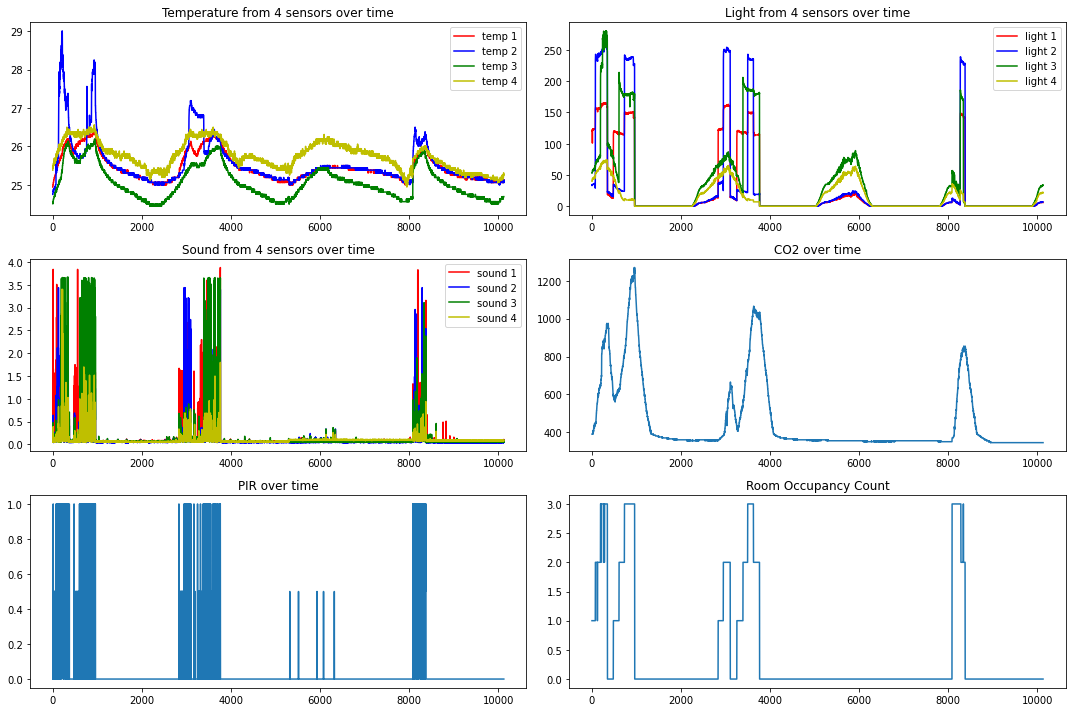

In [6]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)

plt.subplot(321)
plt.title('Temperature from 4 sensors over time')
plt.plot(OE_df['S1_Temp'], label='temp 1', c='r')
plt.plot(OE_df['S2_Temp'], label='temp 2', c='b')
plt.plot(OE_df['S3_Temp'], label='temp 3', c='g')
plt.plot(OE_df['S4_Temp'], label='temp 4', c='y')
plt.legend()

plt.subplot(322)
plt.title('Light from 4 sensors over time')
plt.plot(OE_df['S1_Light'], label='light 1', c='r')
plt.plot(OE_df['S2_Light'], label='light 2', c='b')
plt.plot(OE_df['S3_Light'], label='light 3', c='g')
plt.plot(OE_df['S4_Light'], label='light 4', c='y')
plt.legend()

plt.subplot(323)
plt.title('Sound from 4 sensors over time')
plt.plot(OE_df['S1_Sound'], label='sound 1', c='r')
plt.plot(OE_df['S2_Sound'], label='sound 2', c='b')
plt.plot(OE_df['S3_Sound'], label='sound 3', c='g')
plt.plot(OE_df['S4_Sound'], label='sound 4', c='y')
plt.legend()


plt.subplot(324)
plt.title('CO2 over time')
plt.plot(OE_df['S5_CO2'])

plt.subplot(325)
plt.title('PIR over time')
plt.plot(OE_df[['S6_PIR', 'S7_PIR']].mean(axis=1))

plt.subplot(326)
plt.title('Room Occupancy Count')
plt.plot(OE_df['Room_Occupancy_Count'])

We also need to plot the distribution in order to make decision on standardizing data.

(array([8228.,    0.,    0.,  459.,    0.,    0.,  748.,    0.,    0.,
         694.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

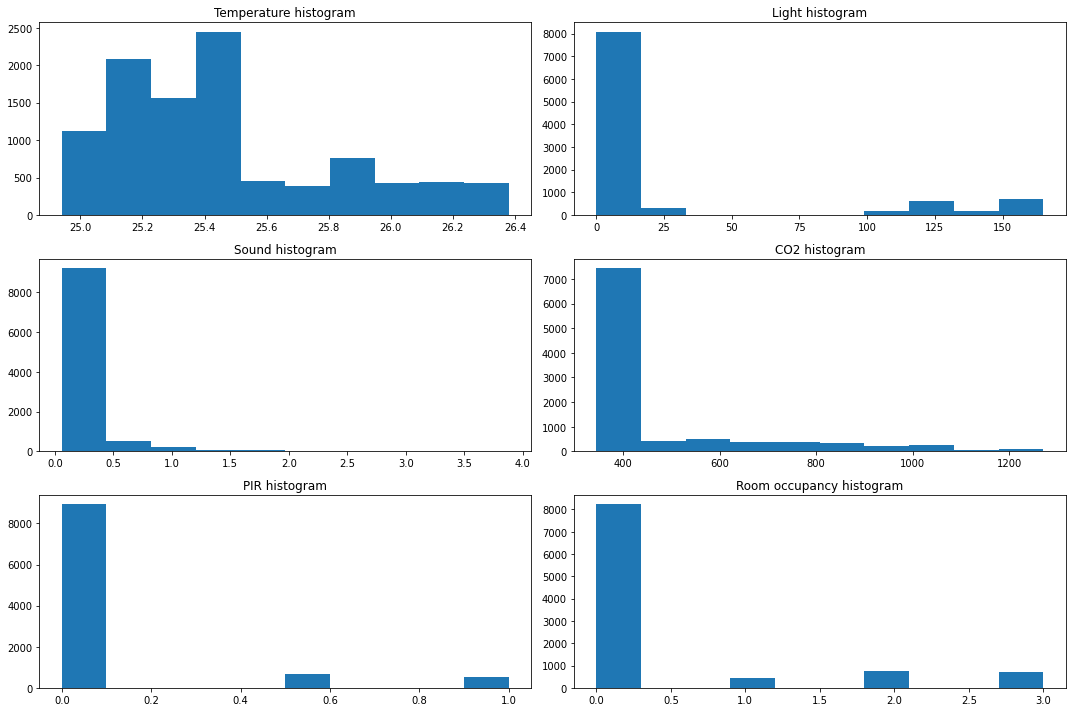

In [7]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)

plt.subplot(321)
plt.title('Temperature histogram')
plt.hist(OE_df['S1_Temp'])

plt.subplot(322)
plt.title('Light histogram')
plt.hist(OE_df['S1_Light'])

plt.subplot(323)
plt.title('Sound histogram')
plt.hist(OE_df['S1_Sound'])

plt.subplot(324)
plt.title('CO2 histogram')
plt.hist(OE_df['S5_CO2'])

plt.subplot(325)
plt.title('PIR histogram')
plt.hist(OE_df[['S6_PIR', 'S7_PIR']].mean(axis=1))

plt.subplot(326)
plt.title('Room occupancy histogram')
plt.hist(OE_df['Room_Occupancy_Count'])

From the above diagram, we could notice that the features are having similar trend over time. The increasing of one feature will always accompanied with increasing of other features.

#### Correlation Heatmap

In [8]:
OE_df.iloc[:, 2:].corr().style.background_gradient(cmap='coolwarm')

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
S1_Temp,1.000000,0.799707,0.948839,0.855279,0.680743,0.548735,0.645163,0.212217,0.436099,0.391137,0.438769,0.355826,0.866718,0.137391,0.436363,0.474077,0.700868
S2_Temp,0.799707,1.000000,0.765525,0.696581,0.639773,0.645987,0.607349,0.370897,0.438274,0.409545,0.427133,0.378724,0.743722,0.202547,0.476901,0.465884,0.671263
S3_Temp,0.948839,0.765525,1.000000,0.885186,0.594311,0.500054,0.642601,0.301419,0.375183,0.344026,0.398177,0.326182,0.821308,0.095842,0.403355,0.460309,0.652047
S4_Temp,0.855279,0.696581,0.885186,1.000000,0.581482,0.456350,0.588459,0.386871,0.355111,0.312594,0.340808,0.294939,0.650320,0.106208,0.340000,0.339037,0.526509
S1_Light,0.680743,0.639773,0.594311,0.581482,1.000000,0.842090,0.816438,0.510853,0.601166,0.534274,0.494080,0.441712,0.602740,0.498185,0.607159,0.545213,0.849058
S2_Light,0.548735,0.645987,0.500054,0.456350,0.842090,1.000000,0.709579,0.458914,0.503021,0.560630,0.439269,0.413932,0.566764,0.493281,0.554658,0.556797,0.788764
S3_Light,0.645163,0.607349,0.642601,0.588459,0.816438,0.709579,1.000000,0.579484,0.502606,0.434859,0.577151,0.473606,0.650829,0.447708,0.501836,0.577815,0.793081
S4_Light,0.212217,0.370897,0.301419,0.386871,0.510853,0.458914,0.579484,1.000000,0.293632,0.303949,0.169702,0.200793,0.148608,0.212718,0.324545,0.220196,0.355715
S1_Sound,0.436099,0.438274,0.375183,0.355111,0.601166,0.503021,0.502606,0.293632,1.000000,0.560062,0.540736,0.557733,0.391903,0.335772,0.522015,0.463040,0.573748
S2_Sound,0.391137,0.409545,0.344026,0.312594,0.534274,0.560630,0.434859,0.303949,0.560062,1.000000,0.529830,0.578635,0.333836,0.357235,0.485697,0.507231,0.557853


#### Feature Engineering and Selection
We will use high correlation filter method. We first choose features having high correlation with target (larger than 0.55). Then, we delete one of the feature from each feature pair if they have correlation larger than 0.5

In [9]:
selected_OE = OE_df[['S1_Temp', 'S1_Light', 'S1_Sound', 'S5_CO2', 
                     'S5_CO2_Slope', 'S7_PIR', 'Room_Occupancy_Count']]
selected_OE

,S1_Temp,S1_Light,S1_Sound,S5_CO2,S5_CO2_Slope,S7_PIR,Room_Occupancy_Count
0,24.94,121,0.08,390,0.769231,0,1
1,24.94,121,0.93,390,0.646154,0,1
2,25.00,121,0.43,390,0.519231,0,1
3,25.00,121,0.41,390,0.388462,0,1
4,25.00,121,0.18,390,0.253846,0,1
...,...,...,...,...,...,...,...
10124,25.06,6,0.09,345,0.000000,0,0
10125,25.06,6,0.07,345,0.000000,0,0
10126,25.13,6,0.11,345,0.000000,0,0
10127,25.13,6,0.08,345,0.000000,0,0


In [10]:
from sklearn.preprocessing import StandardScaler
selected_OE_X = StandardScaler().fit_transform(selected_OE.iloc[:, :6])
selected_OE_y = selected_OE['Room_Occupancy_Count'].to_numpy()

#### Try PCA

In [11]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=12)
# selected_OE_X = pca.fit_transform(OE_df.iloc[:, 2:OE_df.shape[1]-1])
# selected_OE_y = OE_df['Room_Occupancy_Count'].to_numpy()

#### Define Dataset Class
From the distribution of target feature (Room_Occupancy_Count), we notice that 80% percent of the target have class 0. This means we will have 80% correctness if we predict every single case to be 0. We will not have a high correctness for other class. We can deal this by resampling more cases with other classes.

In [12]:
from torch.utils.data import Dataset

class OE_Dataset(Dataset):
    def __init__(self, X, y, seq_len, mode):

        super(OE_Dataset, self).__init__()

        self.X = []
        self.y = []

        for i in range(len(X)-seq_len):
            
            self.X.append(X[i:(i+seq_len)])
            self.y.append(y[i+seq_len])

            # duplicate the cases
            if mode == 'train':
                if y[i+seq_len] == 1 or y[i+seq_len] == 3:
                    self.X.extend([X[i:(i+seq_len)]]*9)
                    self.y.extend([y[i+seq_len]]*9)
                elif y[i+seq_len] == 2:
                    self.X.extend([X[i:(i+seq_len)]]*6)
                    self.y.extend([y[i+seq_len]]*6)
        
        self.X = torch.tensor(np.array(self.X), dtype=torch.float)
        self.y = torch.tensor(np.array(self.y), dtype=torch.long)

        # print out the X shape, y shape, and target size
        print(self.X.shape, self.y.shape)
        print(len(self.y[self.y == 0]))
        print(len(self.y[self.y == 1]))
        print(len(self.y[self.y == 2]))
        print(len(self.y[self.y == 3]))
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### Define Model
Since it is a time series classification, we will first try LSTM (Long short-term memory) Neural Network.

In [13]:
class Lstm(nn.Module):
    def __init__(self, in_dim, lstm_hidden_dim, mlp_hidden_dim):

        super(Lstm, self).__init__()

        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=lstm_hidden_dim,
                            batch_first=True)
        
        self.fc1 = nn.Linear(lstm_hidden_dim, mlp_hidden_dim)

        # dropout layer to regularize
        self.dp = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(mlp_hidden_dim, 4)
        
    def forward(self, x):

        output, (lstm_h, cn) = self.lstm(x)

        x = F.relu(self.fc1(lstm_h[0]))

        x = self.dp(x)

        x = self.fc2(x)

        return x

#### Choose device (Default CPU, GPU if available)

In [14]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


#### Training
We use the first 70% data for training. Since it is time series, we are unable to split and shuffle the data randomly.

In [15]:
seq_len = 5
OE_train_X = selected_OE_X[:int(len(selected_OE)*0.7)]
OE_train_y = selected_OE_y[:int(len(selected_OE)*0.7)]
dataset_train = OE_Dataset(OE_train_X, OE_train_y, seq_len, 'train')

torch.Size([19538, 5, 6]) torch.Size([19538])
5483
4540
4585
4930


We set up parameters for the model and optimizer. The optimizer we choose here is Adam, which is widely used for optimizing deep learning problems, including neural network

In [16]:
in_dim = OE_train_X.shape[1]
lstm_hidden_dim = 8
mlp_hidden_dim = 16
learning_rate = 0.01
model = Lstm(in_dim, lstm_hidden_dim, mlp_hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = du.DataLoader(dataset=dataset_train,
                             batch_size=100, shuffle=True)
model = model.to(device)
model.train()

Lstm(
  (lstm): LSTM(6, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)

#### Start training

In [17]:
epochs = 1000
for epoch in range(1, epochs + 1):
    sum_loss = 0.
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(X)
        #print(output.shape, y.shape)

        loss = F.cross_entropy(output, y)

        sum_loss += loss.item()

        loss.backward()
        optimizer.step()

    sum_loss /= len(train_loader)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {sum_loss:.3f}')

Epoch: 100, Loss: 0.054
Epoch: 200, Loss: 0.045
Epoch: 300, Loss: 0.036
Epoch: 400, Loss: 0.057
Epoch: 500, Loss: 0.033
Epoch: 600, Loss: 0.060
Epoch: 700, Loss: 0.045
Epoch: 800, Loss: 0.039
Epoch: 900, Loss: 0.039
Epoch: 1000, Loss: 0.057


#### Testing

In [18]:
model.eval()
OE_test_X = selected_OE_X[int(len(selected_OE)*0.7):]
OE_test_y = selected_OE_y[int(len(selected_OE)*0.7):]
dataset_test = OE_Dataset(OE_test_X, OE_test_y, seq_len, 'test')
test_loader = du.DataLoader(dataset=dataset_test,
                             batch_size=100, shuffle=False)
correct = 0
preds = []

with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)

        output = model(X)

        output = F.log_softmax(output, dim=1)
        pred = output.max(dim=1)[1]

        preds.extend(pred.cpu().detach().numpy().tolist())

        correct += torch.sum((pred == y))
    
    test_acc = correct / len(test_loader.dataset)
    print(f'accuracy: {test_acc:.4f}',
          f'correct: {correct}')

torch.Size([3034, 5, 6]) torch.Size([3034])
2740
0
93
201
accuracy: 0.9136 correct: 2772


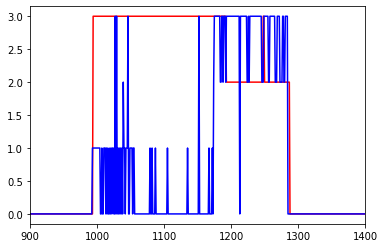

In [19]:
plt.xlim([900, 1400])
plt.plot(OE_test_y, c='r')
plt.plot(preds, c='b')

#### Evaluate
Confusion Matrix

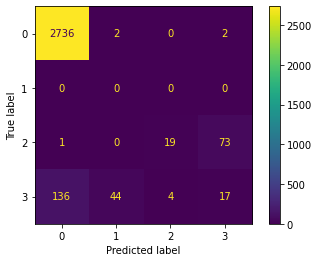

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(OE_test_y[seq_len:], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

F1-Score. We choose the macro F1-score given the extremely unbalanced target.

In [21]:
from sklearn.metrics import f1_score, recall_score, precision_score

recall = recall_score(OE_test_y[seq_len:], preds, average='macro',
                      zero_division=0)
print(f'The recall is {recall:.3f}')
precision = precision_score(OE_test_y[seq_len:], preds, average='macro')
print(f'The precision is {precision:.3f}')
f1_macro = f1_score(OE_test_y[seq_len:], preds, average='macro')
print(f'The F1 macro is {f1_macro:.3f}')

The recall is 0.322
The precision is 0.491
The F1 macro is 0.355
